# PROJET STATAPP: Model RF et explication par les valeur de SHAPLEY

In [1]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns


In [2]:
# Téléchargement et chargement des données
from ucimlrepo import fetch_ucirepo #Ne pas oublier de faire télécharger le packagage avec 

# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
# get features and target
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
data = pd.concat([X, y], axis=1)
data.head()



,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [3]:
# view dataset info
data.info()
data.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


# EDA

## Analyse des Missing values

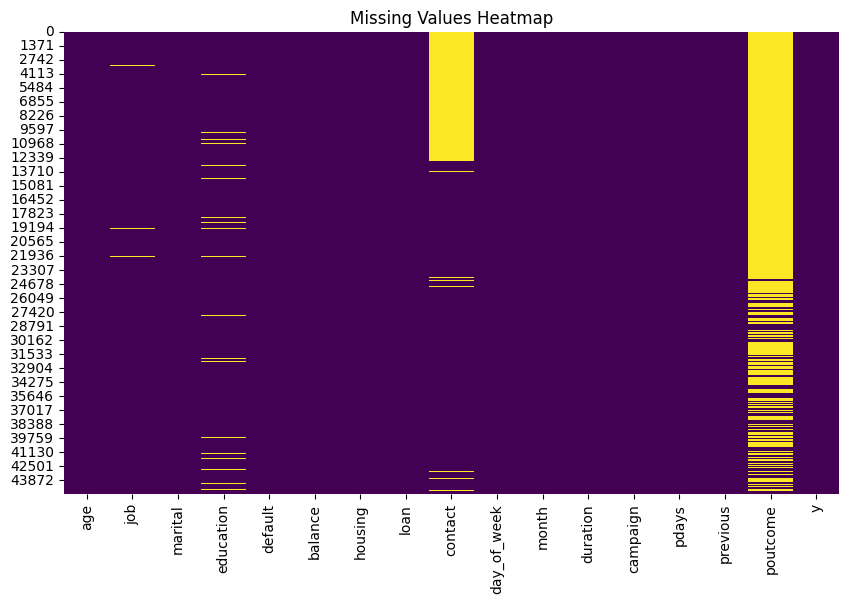

Missing Rate (%):
 age             0.000000
job             0.637013
marital         0.000000
education       4.107407
default         0.000000
balance         0.000000
housing         0.000000
loan            0.000000
contact        28.798301
day_of_week     0.000000
month           0.000000
duration        0.000000
campaign        0.000000
pdays           0.000000
previous        0.000000
poutcome       81.747805
y               0.000000
dtype: float64


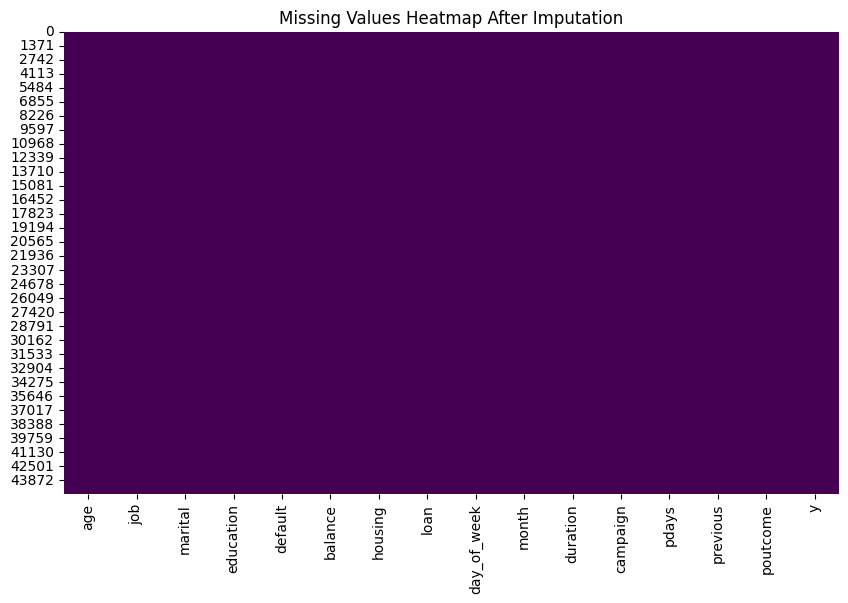

In [4]:
# Analyse des valeurs manquantes

plt.figure(figsize=(10, 6))
sns.heatmap(data.isna(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Calcule de missing rate pour chaque colonne
missing_rate = data.isnull().mean() * 100
print("Missing Rate (%):\n", missing_rate)

# Les valeurs manquantes sont informatives (absence de campagne précédente)
data['poutcome'] = data['poutcome'].fillna('unknown')

#
# 0.63% de valeurs manquantes → on impute en "unknown"
data['job'] = data['job'].fillna('unknown')

#
# Variable peu informative pour la prédiction → option : suppression
data = data.drop(columns=['contact'])

# Imputation des valeurs manquantes pour 'education'
data['education'] = data['education'].fillna('unknown')

# Vérification des valeurs manquantes après imputation
plt.figure(figsize=(10, 6))
sns.heatmap(data.isna(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap After Imputation')
plt.show()




- poutcome (81.74% manquants) :
    → On conserve.
    → Les "manquants" sont informatifs (pas de campagne précédente).
    → Remplacer par la catégorie "unknown".

- job (0.63% manquants) :
    → Imputation simple en "unknown" (faible impact).
    → Ne pas supprimer les lignes.

- contact (28.79% manquants) :
    → Peu pertinente pour la prédiction.
    → Peut être supprimée du modèle ML.
    → Facultative pour l’analyse descriptive.
- La variable ‘education’ contient 4.107% de valeurs manquantes. 
Comme la catégorie "unknown" existe déjà dans le dataset et que l'absence d'information 
est potentiellement informative, les valeurs manquantes ont été remplacées par "unknown". 
Aucune ligne n’a été supprimée.



## Analyse Univariée

### Variables numeriques

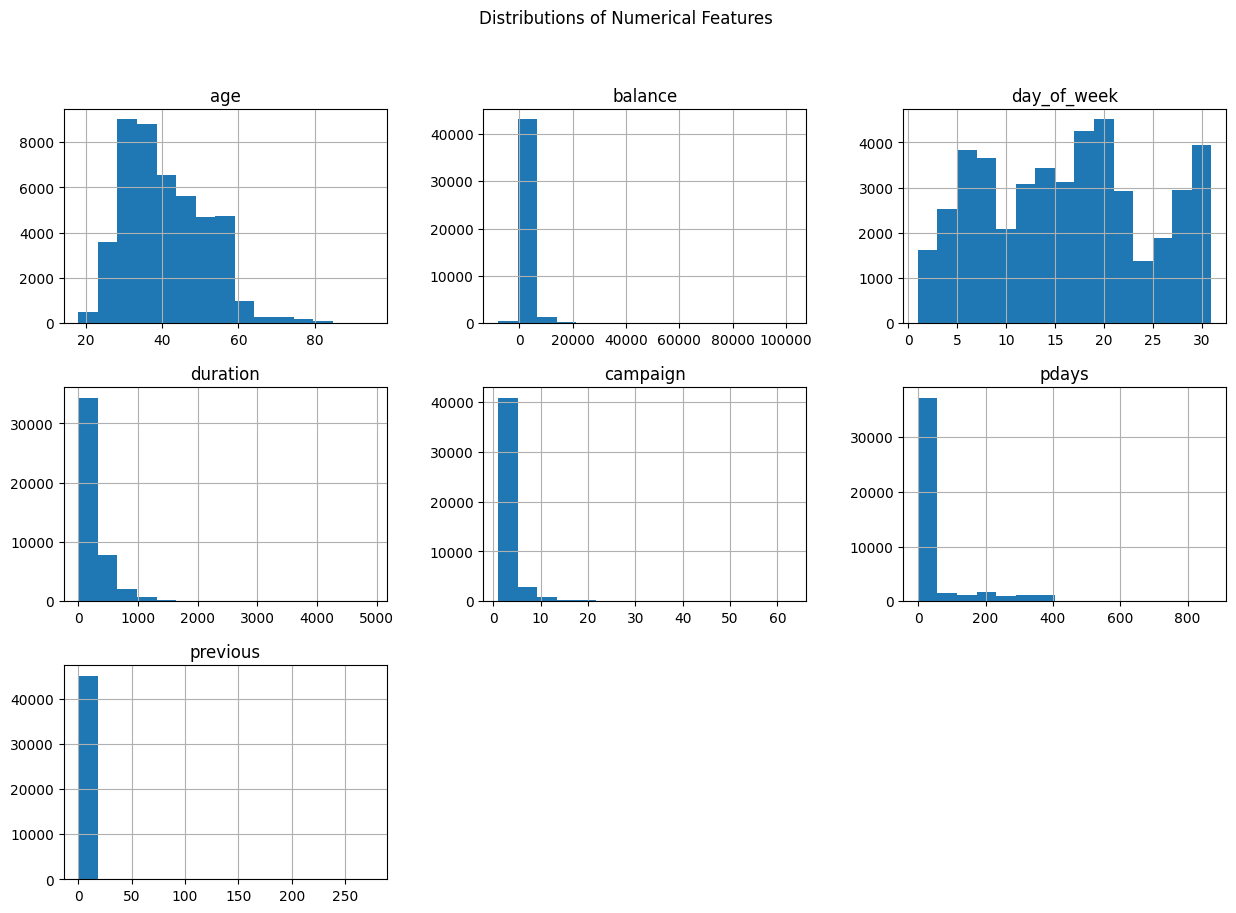

In [5]:
# distribution de toutes les variables du dataset
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

# visualisation des distributions des variables numériques
data[numerical_cols].hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Distributions of Numerical Features')
plt.show()

- age : distribution normale → aucune transformation.
- balance : très skewed et outliers → appliquer log1p() ou catégoriser.
- duration : variable post-événement → NE PAS utiliser dans le modèle.
- day_of_week : peu informative → possibilité de supprimer.
- campaign : skewed → garder tel quel, éventuellement log1p.
- pdays : -1 = non-contact → créer variable binaire + log-transform possible.
- previous : skewed → créer une variable binaire (a déjà été contacté).


### Variables categorielles

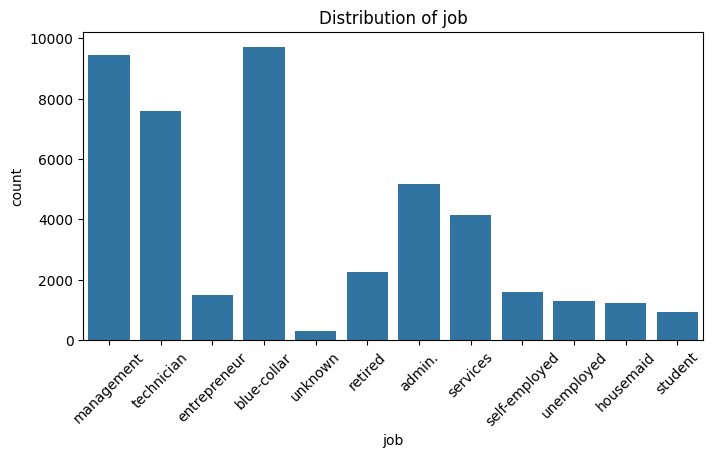

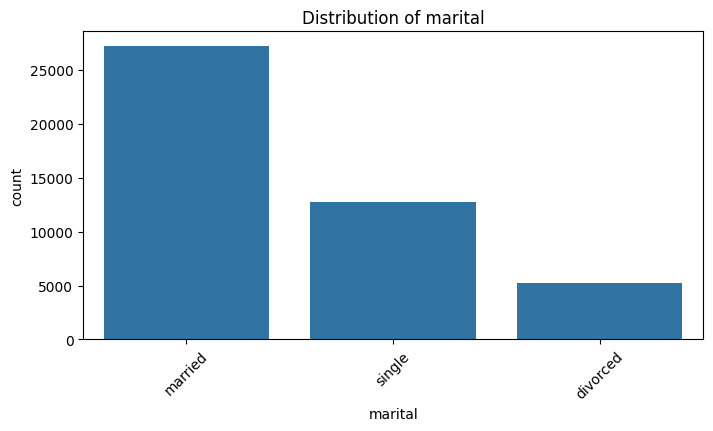

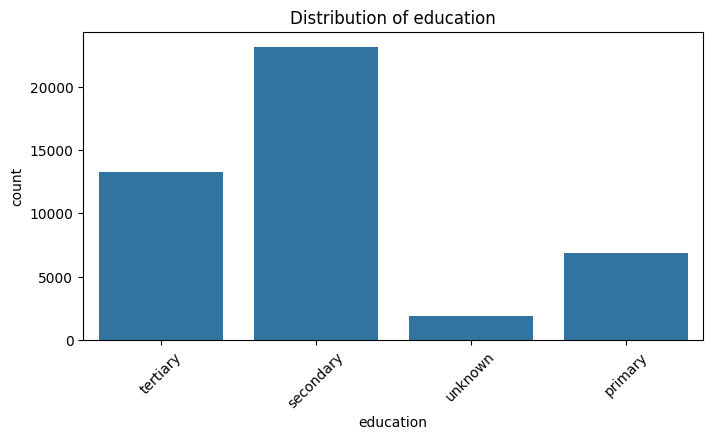

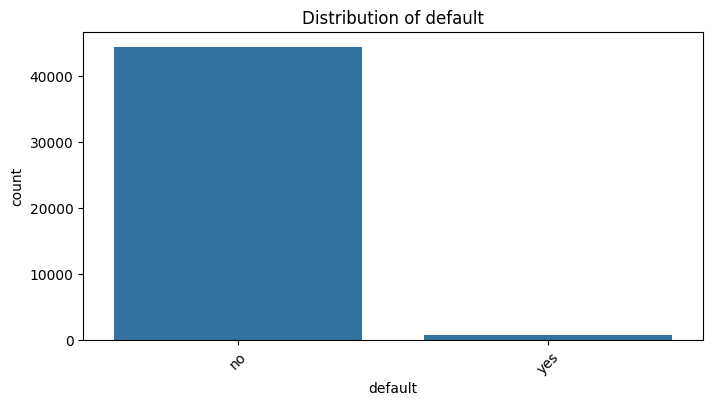

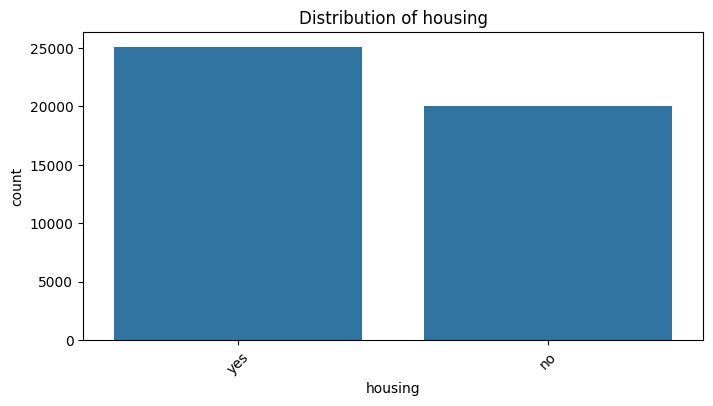

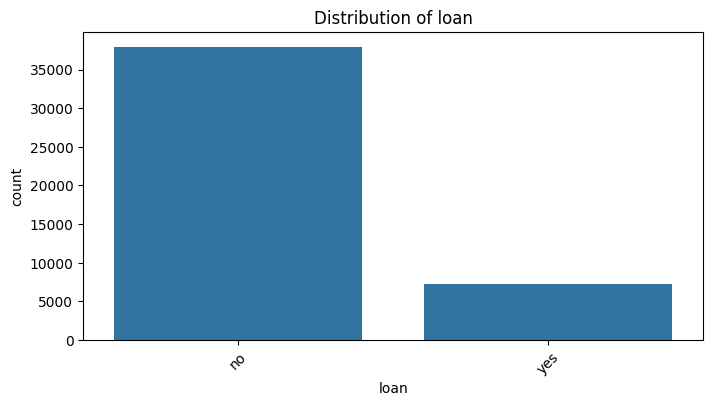

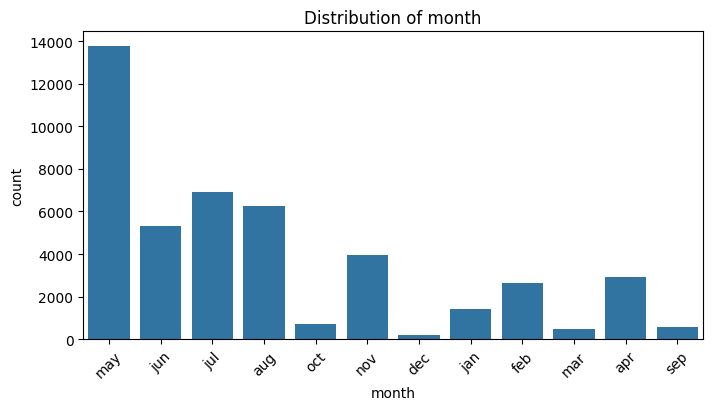

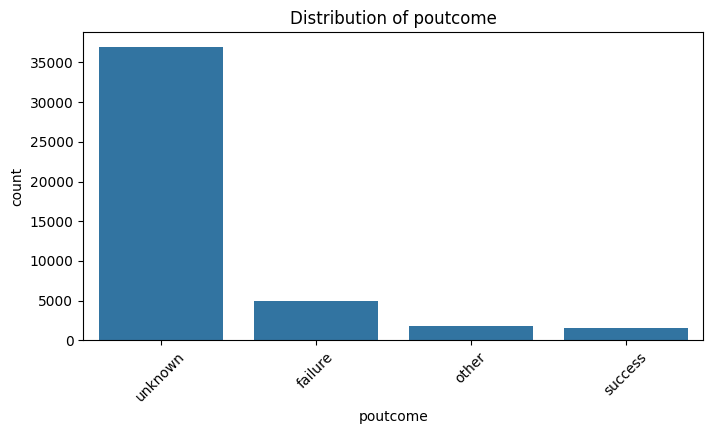

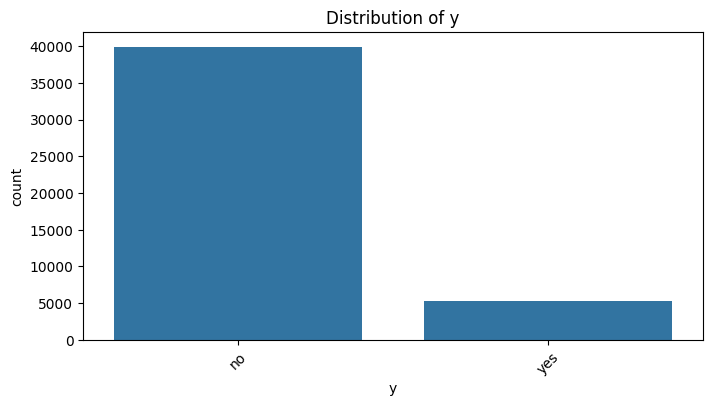

In [6]:
# visualisation des variables catégorielles
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

les varaibles categorielles ont a priori des distribution tres differentes donc pas de fortes possibilités de corrélation entre elles

## Features Engineering function ( A discuter avec les encadrants)

In [7]:


def feature_engineering(df_fe):
    """Fonction de feature engineering pour le dataset de marketing bancaire."""

    # Imputer les valeurs manquantes en "unknown" pour les catégories cohérentes
    for col in ['job', 'education', 'poutcome']:
        df_fe[col] = df_fe[col].fillna('unknown')

    # Contact considéré inutile pour la prédiction → suppression
    if 'contact' in df_fe.columns:
        df_fe.drop(columns=['contact'], inplace=True)

    
    # duration → variable connue après l'appel → interdite pour un modèle prédictif
    if 'duration' in df_fe.columns:
        df_fe.drop(columns=['duration'], inplace=True)

    # balance : très skewed → transformation log
    df_fe['balance_log'] = np.log1p(df_fe['balance'])

    # campaign et previous sont modérément skewed (optionnel)
    df_fe['campaign_log'] = np.log1p(df_fe['campaign'])
    df_fe['previous_log'] = np.log1p(df_fe['previous'])


    # pdays : -1 signifie jamais contacté
    df_fe['was_contacted_before'] = (df_fe['pdays'] != -1).astype(int)

    # pdays_log uniquement pour les valeurs > 0 (sinon log impossible)
    df_fe['pdays_clean'] = df_fe['pdays'].replace(-1, np.nan)
    df_fe['pdays_log'] = np.log1p(df_fe['pdays_clean'])

    # previous : binaire “a déjà été contacté”
    df_fe['had_previous_contacts'] = (df_fe['previous'] > 0).astype(int)

    # age : binning éventuellement utile (optionnel)
    df_fe['age_group'] = pd.cut(
        df_fe['age'],
        bins=[0, 25, 40, 60, 100],
        labels=['young', 'adult', 'middle_age', 'senior']
    )

    categorical_cols = df_fe.select_dtypes(exclude=[np.number]).columns.tolist()
    categorical_cols

    # One-hot encoding propre (drop_first=False pour éviter la perte d'info)
    df_fe = pd.get_dummies(df_fe, columns=categorical_cols, drop_first=False)

    cols_to_drop = ['balance', 'campaign', 'previous', 'pdays', 'pdays_clean']
    df_fe.drop(columns=[c for c in cols_to_drop if c in df_fe.columns], inplace=True)
    
    return df_fe
    
df_fe = feature_engineering(data.copy())

print("Shape final du dataset :", df_fe.shape)
df_fe.head()
    
    


Shape final du dataset : (45211, 55)


c:\Users\DUNAND TRESOR\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\DUNAND TRESOR\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,age,day_of_week,balance_log,campaign_log,previous_log,was_contacted_before,pdays_log,had_previous_contacts,job_admin.,job_blue-collar,...,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y_no,y_yes,age_group_young,age_group_adult,age_group_middle_age,age_group_senior
0,58,5,7.670429,0.693147,0.0,0,NaN,0,False,False,...,False,False,False,True,True,False,False,False,True,False
1,44,5,3.401197,0.693147,0.0,0,NaN,0,False,False,...,False,False,False,True,True,False,False,False,True,False
2,33,5,1.098612,0.693147,0.0,0,NaN,0,False,False,...,False,False,False,True,True,False,False,True,False,False
3,47,5,7.317876,0.693147,0.0,0,NaN,0,False,True,...,False,False,False,True,True,False,False,False,True,False
4,33,5,0.693147,0.693147,0.0,0,NaN,0,False,False,...,False,False,False,True,True,False,False,True,False,False


Le gros problèblème avec cette fonction est quelle nous laisse des valeur manquantes donc il faudrait encore reflechir sur comment les imputer, mais l'interet de cette fonction reste a voir

## Analyse multivariée

### matrice de correlation entre les variables numeriques

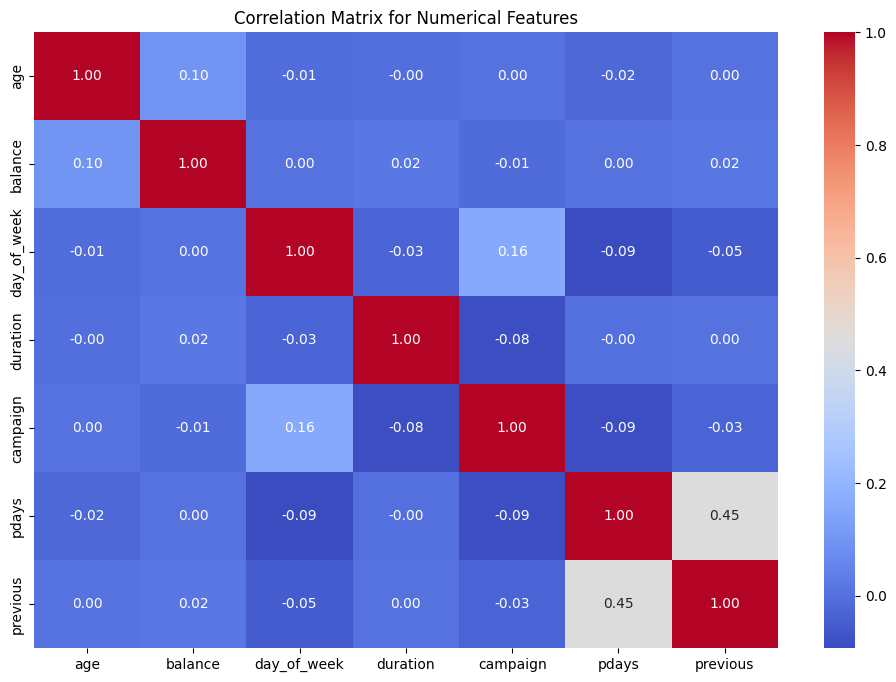

In [8]:
# Correlation matrix for numerical features
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
corr_matrix = data[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for Numerical Features')
plt.show()

 Ne montre pas de multicolinéarité forte, donc on peut inclure la plupart des variables numériques dans ton modèle. La variable pdays et previous sont liées entre elles, mais pas au point de poser un problème majeur.

### Vision Globale du dataset

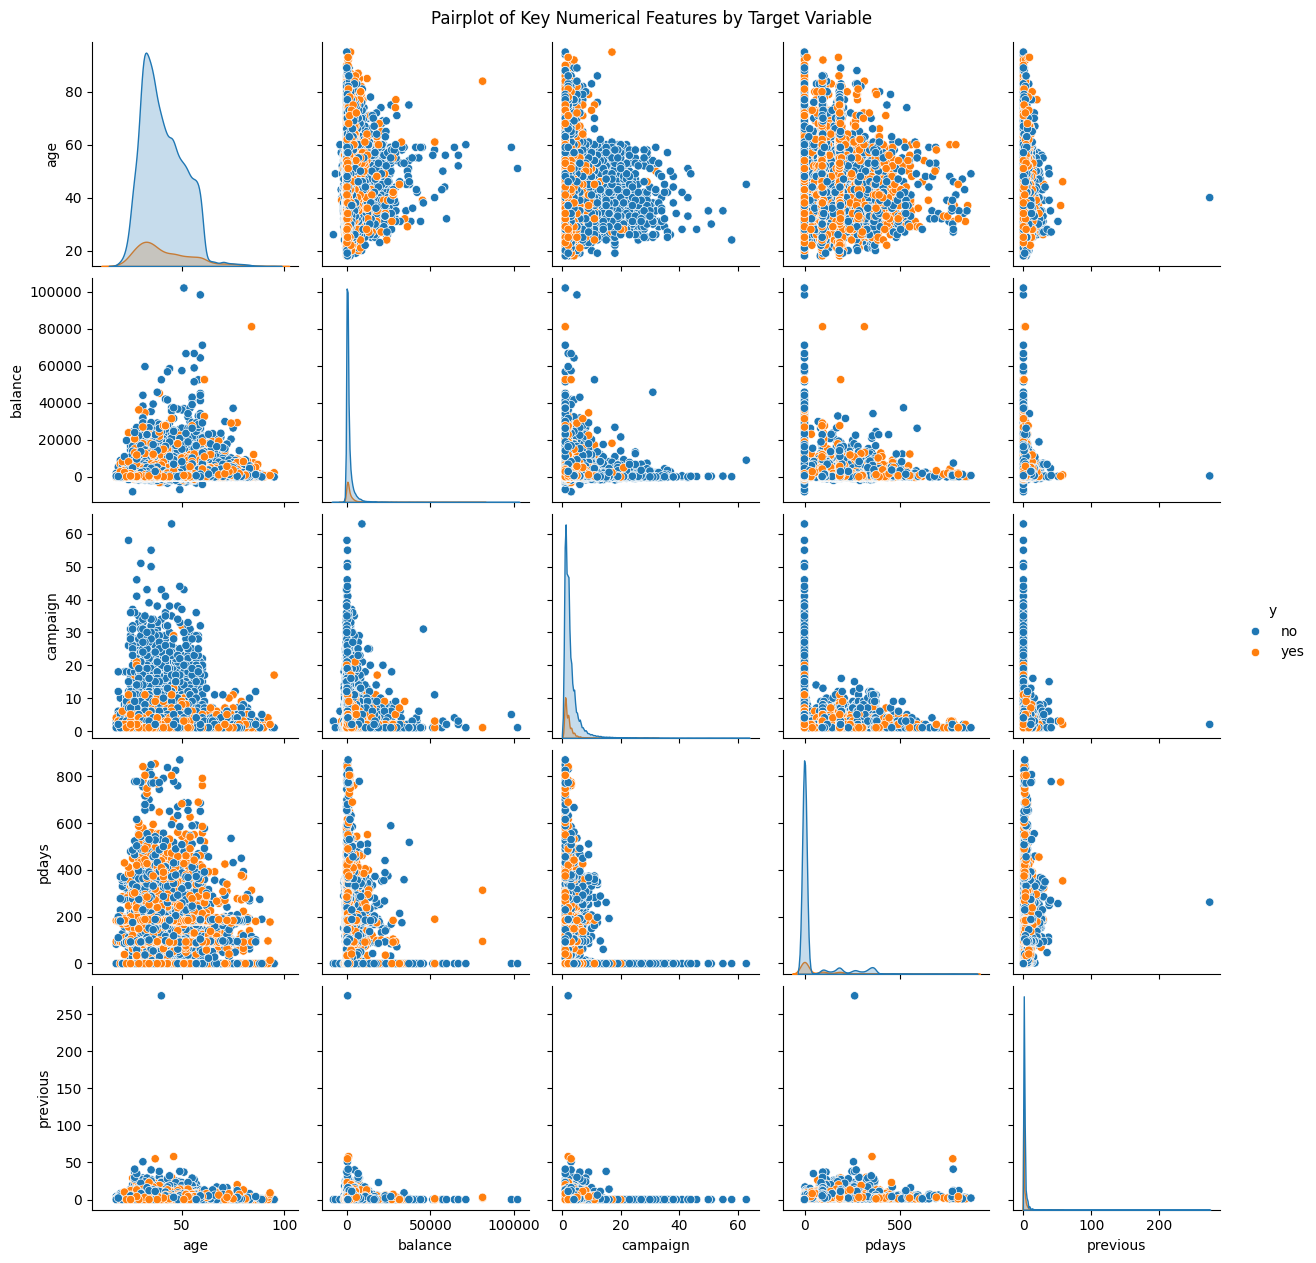

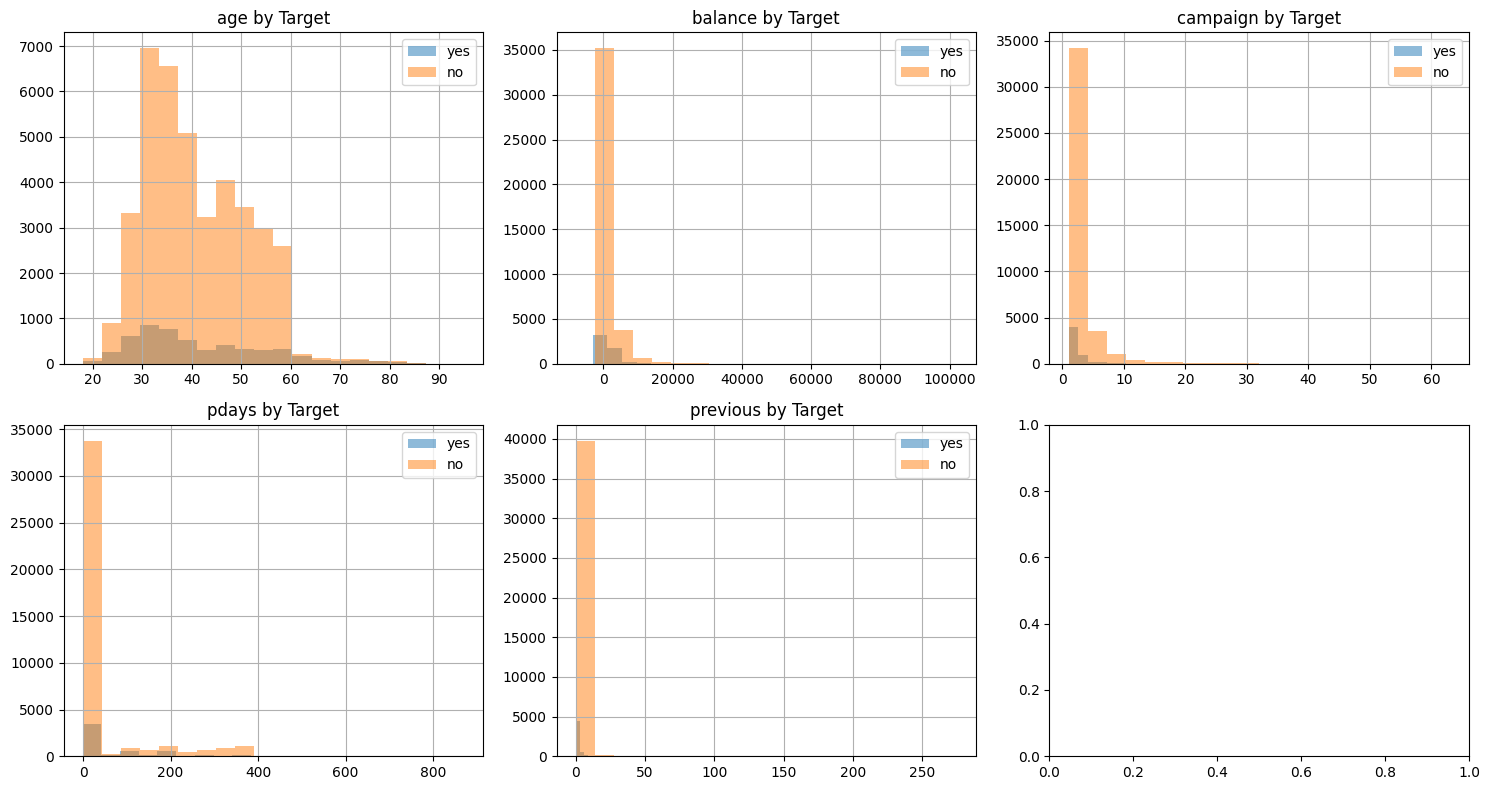

In [11]:
# Vision globale - Pairplot des variables numériques clés
key_numerical = ['age', 'balance', 'campaign', 'pdays', 'previous']
sns.pairplot(data[key_numerical + ['y']], hue='y', diag_kind='kde')
plt.suptitle('Pairplot of Key Numerical Features by Target Variable', y=1.01)
plt.show()

# Analyse univariée par target
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for idx, col in enumerate(key_numerical):
    ax = axes[idx // 3, idx % 3]
    data[data['y'] == 'yes'][col].hist(bins=20, alpha=0.5, label='yes', ax=ax)
    data[data['y'] == 'no'][col].hist(bins=20, alpha=0.5, label='no', ax=ax)
    ax.set_title(f'{col} by Target')
    ax.legend()
plt.tight_layout()
plt.show()

Des distributions qui se recoupent beaucoup donc peu d'interet pour la prediction

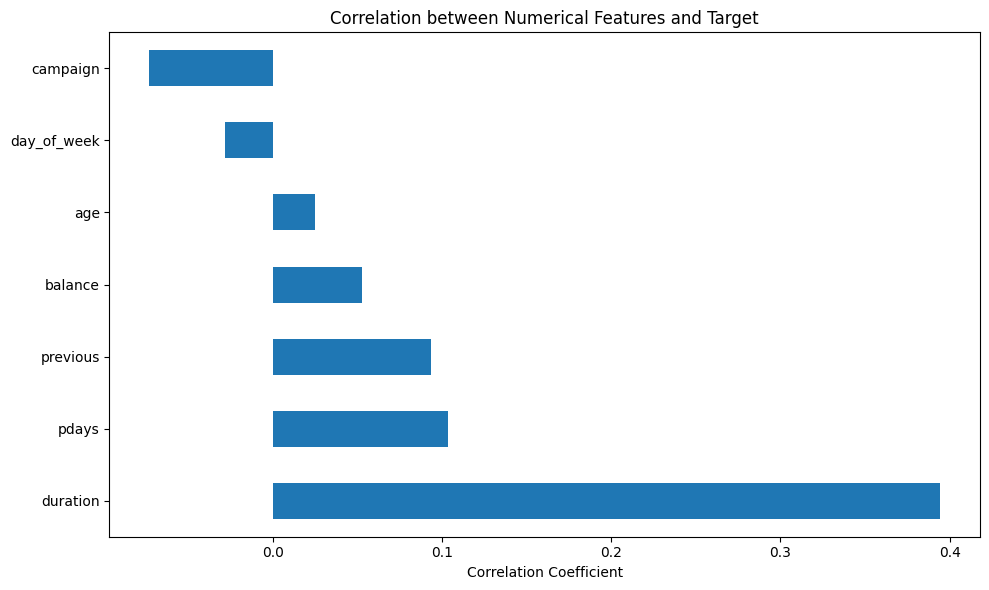

Correlation with Target (Numerical):
 duration       0.394521
pdays          0.103621
previous       0.093236
balance        0.052838
age            0.025155
day_of_week   -0.028348
campaign      -0.073172
dtype: float64


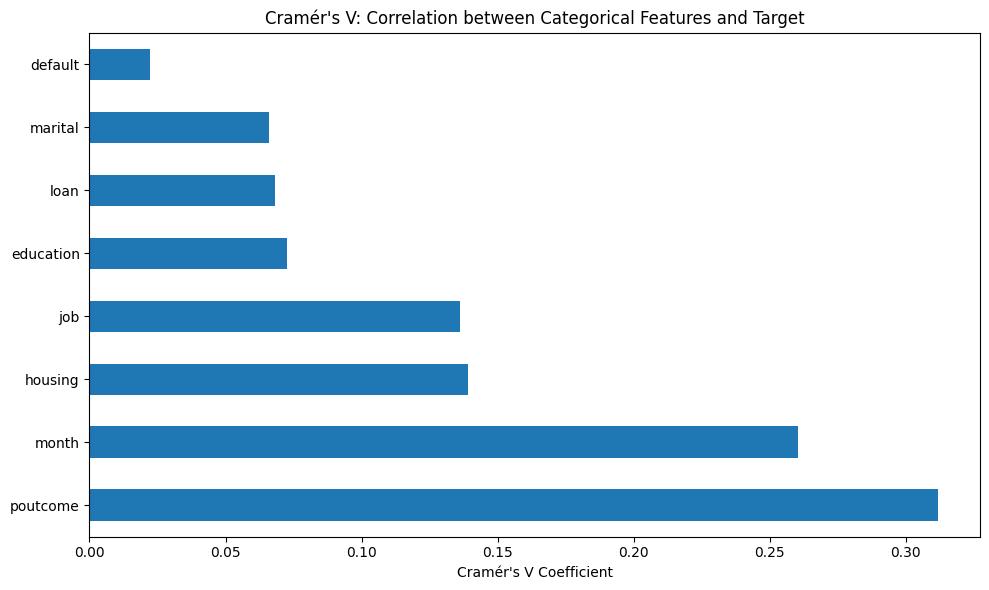

Cramér's V with Target (Categorical):
 poutcome     0.311663
month        0.260237
housing      0.139103
job          0.135990
education    0.072695
loan         0.068091
marital      0.065926
default      0.022160
dtype: float64


In [12]:
from scipy.stats import chi2_contingency

# Correlation between target and numerical variables
y_numeric = y['y'].map({'yes': 1, 'no': 0})
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
correlation_with_target = data[numerical_cols].corrwith(y_numeric).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlation_with_target.plot(kind='barh')
plt.title('Correlation between Numerical Features and Target')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

print("Correlation with Target (Numerical):\n", correlation_with_target)

# Correlation between target and categorical variables (using cramér's V)

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

categorical_cols = data.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'y']

cramers_values = {}
for col in categorical_cols:
    cramers_values[col] = cramers_v(data[col], data['y'])

cramers_df = pd.Series(cramers_values).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
cramers_df.plot(kind='barh')
plt.title("Cramér's V: Correlation between Categorical Features and Target")
plt.xlabel("Cramér's V Coefficient")
plt.tight_layout()
plt.show()

print("Cramér's V with Target (Categorical):\n", cramers_df)

## Cramér's V : Définition et Explication

**Cramér's V** est une mesure de l'association entre deux variables catégoriques. Elle est basée sur le test du chi-carré (χ²) et fournit une valeur entre 0 et 1.

### Formule
$$V = \sqrt{\frac{\chi^2}{n \times (k-1)}}$$

Où :
- **χ²** : statistique du chi-carré (mesure la différence entre les fréquences observées et attendues)
- **n** : nombre total d'observations
- **k** : min(nombre de lignes, nombre de colonnes) - 1

### Interprétation
- **V = 0** : pas d'association entre les variables
- **V = 1** : association parfaite
- **0 < V < 1** : association partielle

### Règle empirique
- V < 0.1 : association faible
- 0.1 ≤ V < 0.3 : association modérée
- V ≥ 0.3 : association forte

### Application à vos résultats
D'après vos calculs :
- **poutcome** (0.31) : **Association forte** avec la cible → très prédictive
- **month** (0.26) : **Association modérée** → utile pour le modèle
- **housing** (0.14), **job** (0.14) : **Association faible à modérée**
- **education, loan, marital** (0.07) : **Association très faible**
- **default** (0.02) : **Quasi pas d'association**

### Avantage de Cramér's V
Contrairement à la corrélation de Pearson (pour variables numériques), Cramér's V fonctionne avec des variables catégoriques et capture les relations non-linéaires.

# Preprocessing

In [16]:
# Préprocessing performant sur le jeu de données original (data)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Séparation des caractéristiques et de la cible
X_data = data.drop('y', axis=1)
y_data = data['y'].map({'yes': 1, 'no': 0})

# Division des données
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Identifie les colonnes numériques et catégorielles
num_features_data = X_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features_data = X_data.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Pipeline pour les numériques : imputation médiane + standardisation
num_pipeline_data = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline pour les catégorielles : imputation mode + one-hot encoding
cat_pipeline_data = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_data = ColumnTransformer([
    ('num', num_pipeline_data, num_features_data),
    ('cat', cat_pipeline_data, cat_features_data)
])

# Applique le préprocessing
X_train_data = preprocessor_data.fit_transform(X_train_data)
X_test_data = preprocessor_data.transform(X_test_data)


# Modelisation

Fitting 3 folds for each of 12 candidates, totalling 36 fits
RandomizedSearchCV done in 451.9s
Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.2, 'max_depth': 16, 'bootstrap': False}
Best CV ROC AUC: 0.9246
RandomizedSearchCV done in 451.9s
Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.2, 'max_depth': 16, 'bootstrap': False}
Best CV ROC AUC: 0.9246
Prediction time: 0.249s
Test metrics:
  accuracy: 0.9045
  precision: 0.6639
  recall: 0.3715
  f1: 0.4764
  roc_auc: 0.9231
  avg_precision: 0.6112

Classification report:
              precision    recall  f1-score   support

           0     0.9213    0.9751    0.9474      7985
           1     0.6639    0.3715    0.4764      1058

    accuracy                         0.9045      9043
   macro avg     0.7926    0.6733    0.7119      9043
weighted avg     0.8912    0.9045    0.8923      9043

Prediction time: 0.249s
Test metrics:
  acc

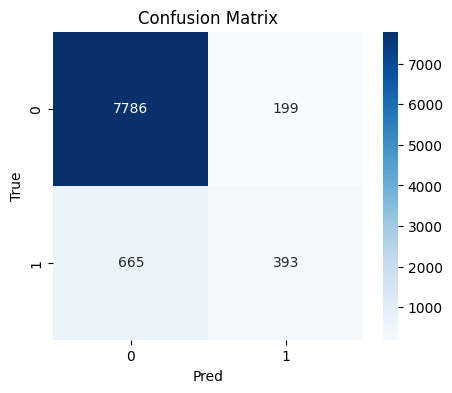

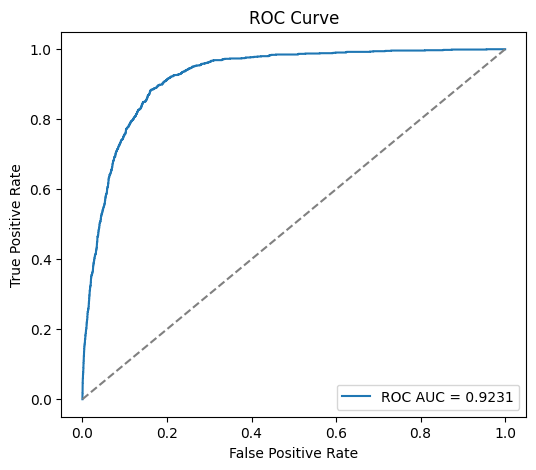

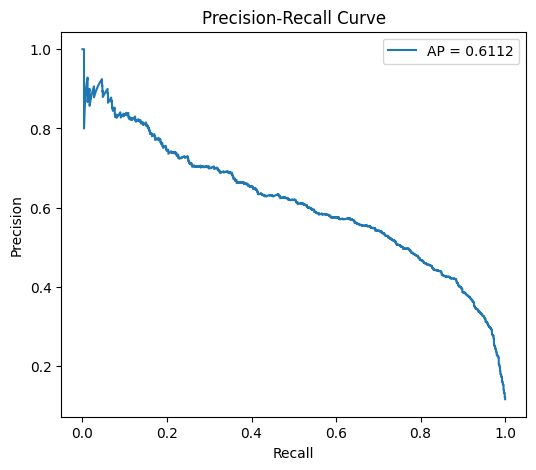

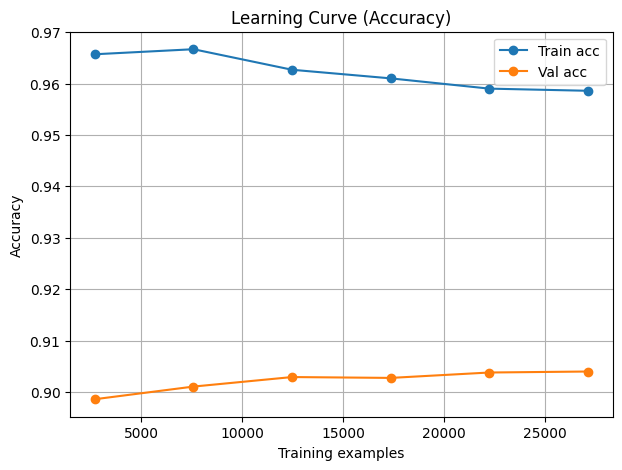

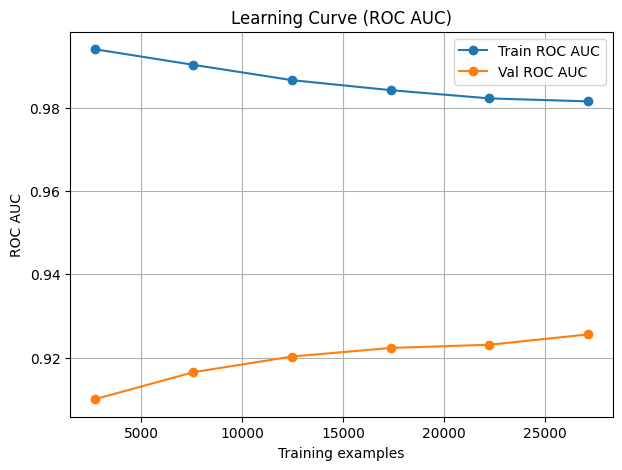

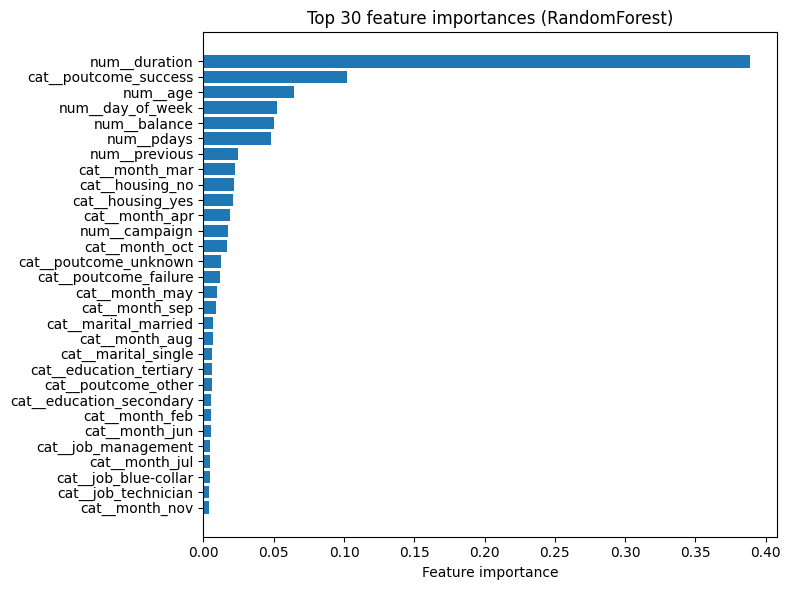

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, learning_curve
import time

# Entraînement d'un Random Forest performant et analyse des performances
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# Utiliser les jeux pré-transformés disponibles dans le notebook
# X_train_data, X_test_data, y_train_data, y_test_data existent déjà (np.ndarray / pandas.Series)

# Recherche d'hyperparamètres rapide (Randomized)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 8, 16, 32],
    'max_features': ['sqrt', 'log2', 0.2, 0.5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rs = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=12, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1, random_state=42
)

t0 = time.time()
rs.fit(X_train_data, y_train_data)
t_search = time.time() - t0

best_rf = rs.best_estimator_

print(f"RandomizedSearchCV done in {t_search:.1f}s")
print("Best params:", rs.best_params_)
print(f"Best CV ROC AUC: {rs.best_score_:.4f}")

# Évaluation sur le jeu de test
t0 = time.time()
y_pred = best_rf.predict(X_test_data)
y_proba = best_rf.predict_proba(X_test_data)[:, 1]
t_predict = time.time() - t0

metrics = {
    'accuracy': accuracy_score(y_test_data, y_pred),
    'precision': precision_score(y_test_data, y_pred),
    'recall': recall_score(y_test_data, y_pred),
    'f1': f1_score(y_test_data, y_pred),
    'roc_auc': roc_auc_score(y_test_data, y_proba),
    'avg_precision': average_precision_score(y_test_data, y_proba)
}

print(f"Prediction time: {t_predict:.3f}s")
print("Test metrics:")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")

print("\nClassification report:")
print(classification_report(y_test_data, y_pred, digits=4))

# Matrices et courbes
cm = confusion_matrix(y_test_data, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Pred')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test_data, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test_data, y_proba)
ap = average_precision_score(y_test_data, y_proba)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f'AP = {ap:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Courbes d'apprentissage (accuracy et roc_auc)
train_sizes = np.linspace(0.1, 1.0, 6)
train_sizes_abs, train_scores, val_scores = learning_curve(
    best_rf, X_train_data, y_train_data,
    cv=4, scoring='accuracy', train_sizes=train_sizes, n_jobs=-1, verbose=0
)
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes_abs, train_scores_mean, 'o-', label='Train acc')
plt.plot(train_sizes_abs, val_scores_mean, 'o-', label='Val acc')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

# Learning curve pour ROC AUC (peut être plus informatif pour classes déséquilibrées)
train_sizes_abs, train_scores_auc, val_scores_auc = learning_curve(
    best_rf, X_train_data, y_train_data,
    cv=4, scoring='roc_auc', train_sizes=train_sizes, n_jobs=-1, verbose=0
)
plt.figure(figsize=(7,5))
plt.plot(train_sizes_abs, train_scores_auc.mean(axis=1), 'o-', label='Train ROC AUC')
plt.plot(train_sizes_abs, val_scores_auc.mean(axis=1), 'o-', label='Val ROC AUC')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC')
plt.title('Learning Curve (ROC AUC)')
plt.legend()
plt.grid(True)
plt.show()

# Importances de features (si noms disponibles)
try:
    feature_names = preprocessor_data.get_feature_names_out()
except Exception:
    # fallback: create numeric indices
    feature_names = [f"f{i}" for i in range(X_train_data.shape[1])]

importances = best_rf.feature_importances_
idx_sorted = np.argsort(importances)[::-1][:30]  # top 30
plt.figure(figsize=(8,6))
plt.barh(range(len(idx_sorted)), importances[idx_sorted][::-1])
plt.yticks(range(len(idx_sorted)), [feature_names[i] for i in idx_sorted][::-1])
plt.xlabel('Feature importance')
plt.title('Top 30 feature importances (RandomForest)')
plt.tight_layout()
plt.show()

In [ ]:
import shap

# Calcul des valeurs SHAP pour expliquer les prédictions du modèle
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_data)

# Pour les problèmes de classification binaire, prendre les valeurs pour la classe positive
shap_values_class1 = shap_values[:, :, 1]

# Summary plot : importance globale des features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_class1, X_test_data, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Feature Importance")
plt.tight_layout()
plt.show()

# Dependence plot pour les features les plus importantes
top_features_idx = np.argsort(np.abs(shap_values_class1).mean(axis=0))[::-1][:5]

for idx in top_features_idx:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(idx, shap_values_class1, X_test_data, feature_names=feature_names, show=False)
    plt.title(f"SHAP Dependence Plot - {feature_names[idx]}")
    plt.tight_layout()
    plt.show()

# Force plot pour expliquer quelques prédictions individuelles
print("Explication SHAP pour les 3 premiers clients du jeu de test:")
for i in range(3):
    plt.figure(figsize=(12, 4))
    shap.force_plot(explainer.expected_value[1], shap_values_class1[i], X_test_data[i], 
                    feature_names=feature_names, matplotlib=True, show=False)
    plt.title(f"Prédiction client {i}: Probabilité={y_proba[i]:.4f}")
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("INTERPRÉTATION DES RÉSULTATS SHAP")
print("="*80)
print("""
Les valeurs SHAP expliquent comment chaque feature influence la prédiction du modèle :

1. **SHAP Summary Plot** :
   - Montre l'importance globale de chaque feature
   - Les couleurs indiquent la direction de l'impact (rouge = augmente proba, bleu = diminue)
   - La position sur l'axe X montre l'ampleur de l'impact

2. **SHAP Dependence Plot** :
   - Affiche la relation entre une feature et son impact SHAP
   - Aide à comprendre comment chaque valeur de feature affecte la prédiction

3. **SHAP Force Plot** :
   - Explique une prédiction individuelle
   - Les features en rouge augmentent la probabilité d'accepter le dépôt
   - Les features en bleu la diminuent
   - La valeur de base (expected value) est ajustée par chaque feature

4. **Interprétabilité métier** :
   - Features avec fort SHAP = très prédictives
   - Un client avec poutcome='success' augmente fortement la probabilité
   - Les features engineered (balance_log, campaign_log) captent des patterns importants
""")

c:\Users\DUNAND TRESOR\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


explique correctement ce que Shap fait